# U-K formulation modal synthesis
## Usage example
### Author: piptouque


### Imports


In [6]:
%load_ext autoreload
%autoreload 2

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython.display as ipd

from uk.data import GuitarBodyData, GuitarStringData
from uk.structure import GuitarString, GuitarBody, ForceRamp, ForceNull, ModalSimulation
from util.util import load_data_json, load_data_csv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [7]:
config_path = pathlib.Path('./config/uk')
string_config_path = config_path / 'guitar_string_config.json'
body_config_path = config_path / 'guitar_body_data.csv'
guitar_excitation_config_path = config_path / 'guitar_excitation_config.json'
simulation_config_path = config_path / 'simulation_config.json'
log_config_path = config_path / 'log_config.json'
#
output_path = pathlib.Path('../out/uk')
output_spreadsheet_path = output_path / 'spreadsheets'
output_figure_path = output_path / 'figures'
output_audio_path = output_path / 'sounds'


string = GuitarString(load_data_json(string_config_path, cls=GuitarStringData))
body = GuitarBody(load_data_csv(body_config_path, cls=GuitarBodyData))
ext_force_string = load_data_json(guitar_excitation_config_path, cls=ForceRamp, l=string.data.l)
sim = load_data_json(simulation_config_path, cls=ModalSimulation)
log = load_data_json(log_config_path)

if log.do_save:
    output_spreadsheet_path.mkdir(parents=True, exist_ok=True)
    output_figure_path.mkdir(parents=True, exist_ok=True)
    output_audio_path.mkdir(parents=True, exist_ok=True)

if log.do_log:
    print(f"String data: \n {string.data._param_dict}")
    print(f"Body data: \n {body.data._param_dict}")
    print(f"Simulation config \n {sim._param_dict}")

String data: 
 {'l': 0.65, 't': 73.9, 'rho': 0.0361, 'e': 0.0004, 'i': 1, 'eta_f': 0.0007, 'eta_a': 0.9, 'eta_b': 0.25, 'c_t': 45.244794316499906, 'b': 0.0004}
Body data: 
 {'n': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'f_n': array([ 78.3, 100.2, 187.3, 207.8, 250.9, 291.8, 314.7, 344.5, 399. ,
       429.6, 482.9, 504.2, 553.9, 580.3, 645.7, 723.5]), 'ksi_n': array([0.022, 0.011, 0.016, 0.01 , 0.007, 0.009, 0.011, 0.007, 0.014,
       0.009, 0.007, 0.007, 0.006, 0.014, 0.01 , 0.013]), 'm_n': array([2.91, 0.45, 0.09, 0.25, 2.65, 9.88, 8.75, 8.8 , 0.9 , 0.41, 0.38,
       1.07, 2.33, 1.36, 2.02, 0.45])}
Simulation config 
 {'n': array([0, 1, 2, 3, 4]), 'nb_steps': 500, 'h': 0.001}


### Solve system

In [8]:
# There is no external force applied to the body.
ext_force_body = ForceNull()

# The string and body are initially at rest.
q_n_is = [np.zeros(sim.n.shape, dtype=float) for i in range(2)]
dq_n_is = [np.zeros(sim.n.shape, dtype=float) for i in range(2)]

# Run the simulation / solve the system.
t, q_ns, dq_ns, ddq_ns, ext_force_n_ts = sim.run(
    [string, body], [ext_force_string, ext_force_body],
    q_n_is, dq_n_is)

y_ns = [struct.y_n(q_ns[i], sim.n)
        for (i, struct) in enumerate([string, body])]

# compute data frames from the result.
df_q_n = pd.DataFrame(q_ns[0], index=sim.n, columns=t)
df_dq_n = pd.DataFrame(dq_ns[0], index=sim.n, columns=t)
df_ddq_n = pd.DataFrame(ddq_ns[0], index=sim.n, columns=t)
df_ext_force_n_t = pd.DataFrame(ext_force_n_ts[0], index=sim.n, columns=t)


### Save and plot output

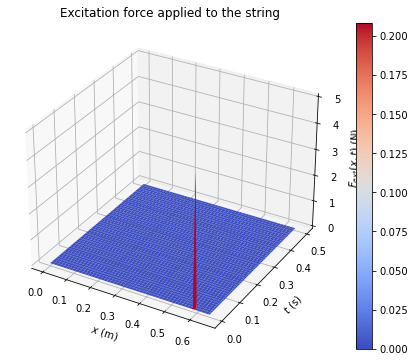

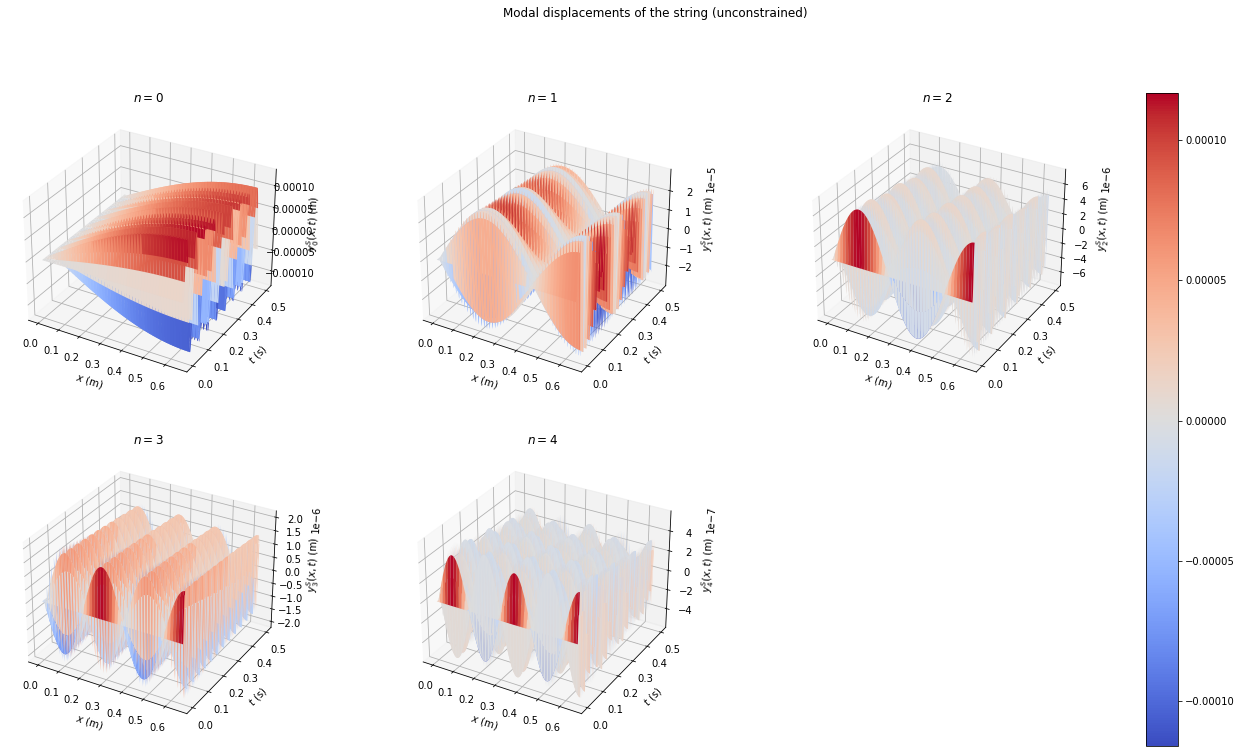

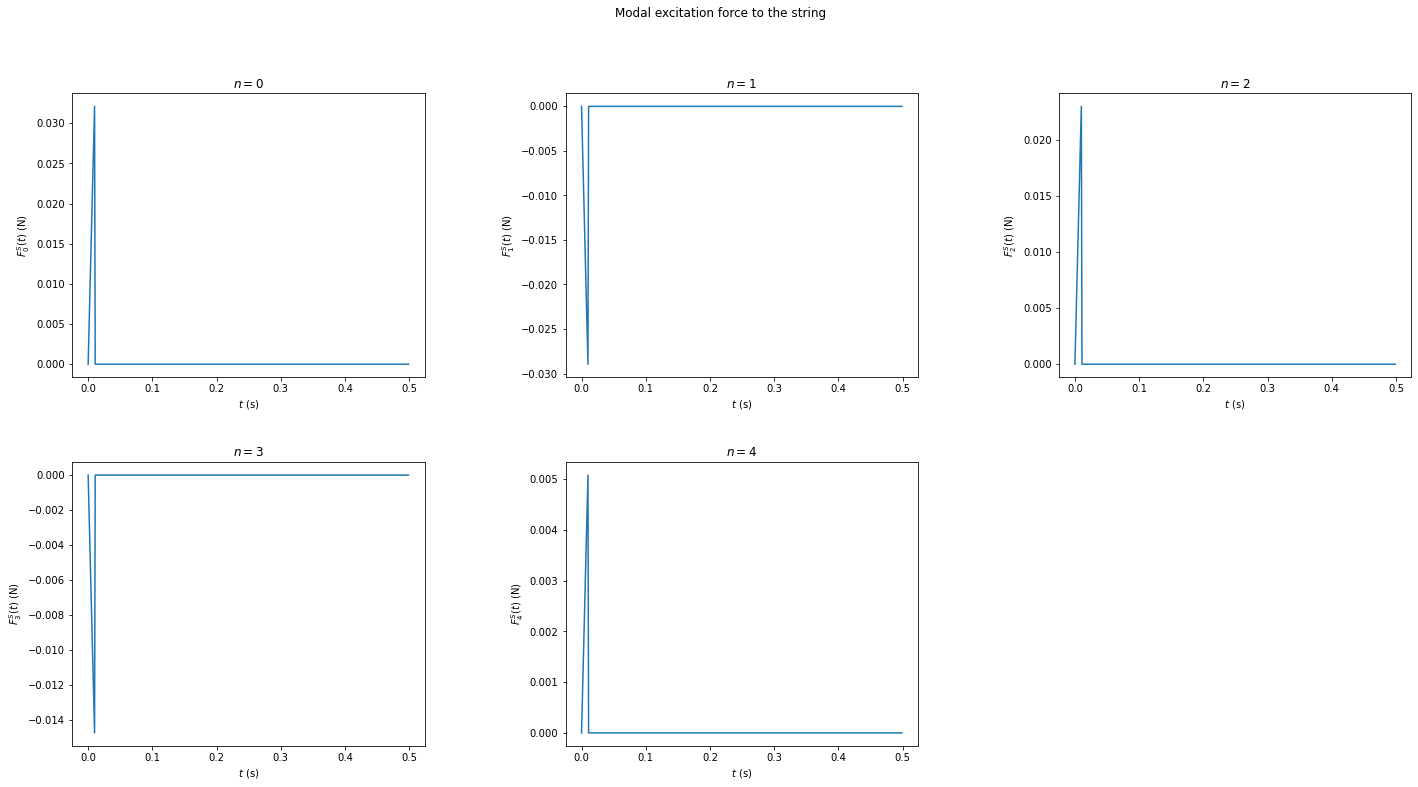

In [9]:
# save the result as required.
x = np.linspace(0, string.data.l, log.plot.nb_points)
xx = np.outer(x, np.ones_like(t))
tt = np.outer(np.ones_like(x), t)

y_n = y_ns[0]
ext_force_n_t = ext_force_n_ts[0]

# Get the total displacement from the sum of the modal displacements.
y = np.empty_like(t)
for j in range(len(y_n)):
    y += y_n[j](log.audio.x_s_rel * string.data.l)


if log.do_log or log.do_save:
    # EXCITATION FORCE ext_force
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    f_x = ext_force_string(xx, tt)
    surf = ax.plot_surface(xx, tt, f_x, cmap='coolwarm')
    ax.set_title(f'Excitation force applied to the string')
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$t$ (s)')
    ax.set_zlabel('$F_{ext}(x, t)$ (N)')
    fig.colorbar(surf, ax=ax)
    if log.do_save:
        fig.savefig(output_figure_path / 'ext_force.svg',
                    facecolor='none', transparent=True)
    if log.do_log:
        plt.show()
    plt.close(fig)

    # MODAL DISPLACEMENTS of the String y_n
    fig = plt.figure(figsize=(8 * (len(y_n)+1)//2, 2*6))
    fig.subplots_adjust(hspace=0.1, wspace=0.4)
    fig.suptitle("Modal displacements of the string (unconstrained)")
    axes = []
    surfs = []
    for (j, y_j) in enumerate(y_n):
        ax = fig.add_subplot(2, len(y_n)//2+1, j+1, projection='3d')
        axes.append(ax)
        y_x = y_j(xx)
        #
        surf = ax.plot_surface(xx, tt, y_x, cmap='coolwarm')
        surfs.append(surf)
        #
        ax.set_title(f'$n={j}$')
        ax.set_xlabel('$x$ (m)')
        ax.set_ylabel('$t$ (s)')
        ax.set_zlabel(f'$y_{j}^S(x, t)$ (m)')
    # add heat map
    fig.colorbar(surfs[0], ax=axes)
    if log.do_save:
        fig.savefig(output_figure_path / 'y_n.svg',
                    facecolor='none', transparent=True)
        wav.write(output_audio_path / 'y.wav', log.audio.sr, y)
    if log.do_log:
        plt.show()

    plt.close(fig)

    # MODAL Excitation ext_force_n_t
    fig = plt.figure(figsize=(8 * (ext_force_n_t.shape[0]+1)//2, 2*6))
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    fig.suptitle("Modal excitation force to the string")
    for (j, ext_force_j) in enumerate(ext_force_n_t):
        ax = fig.add_subplot(2, len(ext_force_n_t) //
                                2+1, j+1)
        #
        ax.plot(t, ext_force_j)
        #
        ax.set_title(f'$n={j}$')
        ax.set_xlabel('$t$ (s)')
        ax.set_ylabel(f'$F_{j}^S(t)$ (N)')
    if log.do_save:
        fig.savefig(output_figure_path / 'ext_force_n.svg',
                    facecolor='none', transparent=True)
    if log.do_log:
        plt.show()
    plt.close(fig)


In [5]:
if log.do_log:
    # need to explicly call display inside any contest in order to render sound.
    # see: https://stackoverflow.com/a/64139240
    ipd.display(ipd.Audio(y / np.max(y), rate=log.audio.sr))